# Sign language recognition using tensorflow

## Getting required packages

Created a virtual environment for tensorflow, using the same.
Installing the packages in virtual environment.

In [1]:
!pip install opencv-python
!pip install --upgrade pyqt5 lxml
!pip install wget

In [2]:
import os
import time
import cv2
import wget
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
import ipywidgets as widgets
import threading

## Define Images to Collect

In [3]:
labels = ['thumbsup', 'thumbsdown', 'thankyou', 'livelong']
number_imgs = 5

## Folders Setup

In [4]:
IMAGES_PATH = os.path.join('Tensorflow', 'workspace', 'images', 'collectedimages')

In [5]:
if not os.path.exists(IMAGES_PATH):
    !mkdir {IMAGES_PATH}

for label in labels:
    path = os.path.join(IMAGES_PATH, label)
    if not os.path.exists(path):
        !mkdir {path}

## Creating dataset (capture images)

**Using the opencv library, saving the images in desired path.**

PS - live webcam window is not used a it is stuck for most of time while cv2 captures images.

In [8]:
for label in labels:
    cap = cv2.VideoCapture(0)      # connects to webcam/camera
    print('Collecting images for {}'.format(label))
    time.sleep(5)
    for imgnum in range(number_imgs):
        print('Collecting image {}'.format(imgnum))
        ret, frame = cap.read()        # capture frame
        imgname = os.path.join(IMAGES_PATH,label,label+'_'+'{}.jpg'.format(imgnum))   # label the captured frame
        cv2.imwrite(imgname, frame)  # write the file
        cv2.imshow('frame', frame)   # show on screen
        time.sleep(2)

        if cv2.waitKey(1) & 0xFF == ord('q'):  # to escape the loop
            break

# below code is to release camera, otherwise kernel dies after execution of loop
cap.release()
cv2.destroyAllWindows()

## Labeling the images

Images are labelled using data labelling tool.

In [6]:
LABELIMG_PATH = os.path.join('Tensorflow', 'labelimg')

In [7]:
if not os.path.exists(LABELIMG_PATH):
    !mkdir {LABELIMG_PATH}
    !git clone https://github.com/tzutalin/labelImg {LABELIMG_PATH}

In [8]:
# Code is generic because os window commands don't work on google colab, it require os 'posix' 

if os.name == 'posix':
    !make qt5py3
if os.name =='nt':
    !cd {LABELIMG_PATH} && pyrcc5 -o libs/resources.py resources.qrc
    
!cd {LABELIMG_PATH} && python labelImg.py

## Moving collected images to a Training and Testing folders

* Partition is done considering 80-20 split for train and test sets

In [9]:
TRAIN_PATH = os.path.join('Tensorflow', 'workspace', 'images', 'train')
TEST_PATH = os.path.join('Tensorflow', 'workspace', 'images', 'test')
ARCHIVE_PATH = os.path.join('Tensorflow', 'workspace', 'images', 'archive.tar.gz')

In [13]:
# automate train test splitting - from IMAGE_PATH to TRAIN_PATH and TEST_PATH
from glob import glob
import shutil
import math

TEST_SIZE = 0.2

if not os.path.exists(TRAIN_PATH):
    !mkdir {TRAIN_PATH}
if not os.path.exists(TEST_PATH):
    !mkdir {TEST_PATH}
    
print('using {} % of images as test data'.format(TEST_SIZE * 100))
for label in labels:
    path = os.path.join(IMAGES_PATH, label)
    xml_filenames = glob(path+'/*.xml')
    n_files = len(xml_filenames)
    n_test = math.floor(n_files * TEST_SIZE)
    for i, xml in enumerate(xml_filenames):
        jpg = xml.replace('.xml', '.jpg')
        if i >= n_test:
            dest_folder = TRAIN_PATH
        else:
            dest_folder = TEST_PATH
        shutil.move(xml, dest_folder)
        shutil.move(jpg, dest_folder)
    print('{} -> annotated_images: {} train: {} test: {}'.format(label, n_files, n_files - n_test, n_test))

# deleting old images dir 
os.rmdir(path)

using 20.0 % of images as test data
thumbsup -> annotated_images: 5 train: 4 test: 1
thumbsdown -> annotated_images: 5 train: 4 test: 1
thankyou -> annotated_images: 5 train: 4 test: 1
livelong -> annotated_images: 5 train: 4 test: 1


## Model Paths Setup  

In [7]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [8]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [9]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [10]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

## Download TF Pretrained Models from Tensorflow Model Zoo

Choosing a light weight and flexible to run over the platforms, I chose "SSD MobileNet V2 FPNLite 320x320" model, it is fast (speed 22 ms) and has descent mean average precision of 22.2 from [Tensorflow zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md)    <br>
[Here](https://www.tensorflow.org/install/source_windows) is the installation guide.

In [14]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}
    

Cloning into 'Tensorflow\models'...
Updating files:  80% (2523/3116)
Updating files:  81% (2524/3116)
Updating files:  82% (2556/3116)
Updating files:  83% (2587/3116)
Updating files:  84% (2618/3116)
Updating files:  85% (2649/3116)
Updating files:  86% (2680/3116)
Updating files:  87% (2711/3116)
Updating files:  88% (2743/3116)
Updating files:  89% (2774/3116)
Updating files:  90% (2805/3116)
Updating files:  91% (2836/3116)
Updating files:  92% (2867/3116)
Updating files:  93% (2898/3116)
Updating files:  94% (2930/3116)
Updating files:  95% (2961/3116)
Updating files:  96% (2992/3116)
Updating files:  97% (3023/3116)
Updating files:  98% (3054/3116)
Updating files:  99% (3085/3116)
Updating files: 100% (3116/3116)
Updating files: 100% (3116/3116), done.


In [15]:
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

100% [..........................................................................] 1468733 / 1468733        1 file(s) moved.
        1 file(s) copied.
running build
running build_py
creating build
creating build\lib
creating build\lib\object_detection
copying object_detection\eval_util.py -> build\lib\object_detection
copying object_detection\eval_util_test.py -> build\lib\object_detection
copying object_detection\exporter.py -> build\lib\object_detection
copying object_detection\exporter_lib_tf2_test.py -> build\lib\object_detection
copying object_detection\exporter_lib_v2.py -> build\lib\object_detection
copying object_detection\exporter_main_v2.py -> build\lib\object_detection
copying object_detection\exporter_tf1_test.py -> build\lib\object_detection
copying object_detection\export_inference_graph.py -> build\lib\object_detection
copying object_detection\export_tflite_graph_lib_tf2.py -> build\lib\object_detection
copying object_detection\export_tflite_graph_lib_tf2_test.py -> build

zip_safe flag not set; analyzing archive contents...
object_detection.core.__pycache__.densepose_ops.cpython-310: module references __file__
object_detection.core.__pycache__.preprocessor.cpython-310: module MAY be using inspect.stack
object_detection.utils.__pycache__.autoaugment_utils.cpython-310: module MAY be using inspect.stack
C:\Users\NYK-PC\AppData\Local\Temp\easy_install-c4y8qh45\apache-beam-2.40.0\setup.py:155: UserWarning: This version of Apache Beam has not been sufficiently tested on Python 3.10. You may encounter bugs or missing features.
  warnings.warn(
E:\Study Material\ASL scratch\venv\tf_asl\lib\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\NYK-PC\AppData\Local\Temp\easy_install-c4y8qh45\apache-beam-2.40.0\apache_beam\coders\coder_impl.pxd
  tree = Parsing.p_module(s, pxd, full_module_name)
E:\Study Material\ASL scratch\venv\tf_asl\lib\sit

Obtaining file:///E:/Study%20Material/ASL%20scratch/Sign%20Language%20Detection/Tensorflow/models/research/slim
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py develop for slim


In [16]:
# Code for verification_script and check if installation is done.
# !pip install tensorflow --upgrade
# !pip install scipy
# !pip install tensorflow.io
# !pip uninstall protobuf matplotlib -y
# !pip install protobuf==3.19.0 matplotlib
# !pip install tf-models-official
# !pip install Pillow
# !pip install pyyaml

VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

Running tests under Python 3.10.3: E:\Study Material\ASL scratch\venv\tf_asl\Scripts\python.exe
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2022-08-05 02:57:17.895909: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-05 02:57:18.370971: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2781 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1
E:\Study Material\ASL scratch\venv\tf_asl\lib\site-packages\object_detection-0.1-py3.10.egg\object_detection\builders\model_builder.py:1102: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  logging.warn(

In [19]:
import object_detection

In [18]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

100% [........................................................................] 20515344 / 20515344        1 file(s) moved.


x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/checkpoint
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.index
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/saved_model.pb
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/variables.data-00000-of-00001
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/variables.index


## Create Label Map
Annotations

In [20]:
labels = [{'name':'ThumbsUp', 'id':1}, {'name':'ThumbsDown', 'id':2}, {'name':'ThankYou', 'id':3}, {'name':'LiveLong', 'id':4}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

## Create TF records

In [21]:
# OPTIONAL IF RUNNING ON COLAB
ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'archive.tar.gz')
if os.path.exists(ARCHIVE_FILES):
  !tar -zxvf {ARCHIVE_FILES}

In [22]:
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

Cloning into 'Tensorflow\scripts'...


In [23]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

Successfully created the TFRecord file: Tensorflow\workspace\annotations\train.record
Successfully created the TFRecord file: Tensorflow\workspace\annotations\test.record


## Cloning Model Config to Train Folder

In [24]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

        1 file(s) copied.


## Update Config For Transfer Learning

In [25]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [26]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [27]:
config

{'model': ssd {
   num_classes: 90
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 4e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.01
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.997
         scale: true
         epsilon: 0.001
       }
     }
     use_depthwise: true
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
       additional_layer_depth: 128
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   matcher {
     argmax_matcher {
       matched_threshold: 0.5
   

In [28]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [29]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [30]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

### CUDA and cuDNN
According to installation guide (here)[https://www.tensorflow.org/install/source_windows], we can choose the right version of CUDA and cuDNN to execute code faster using Nvidia GPU <br>
Hence, I downloaded CUDA 11.2 and cuDNN 8.1

In [31]:
# installing the same version of tensorflow-GPU
# !pip install --upgrade tensorflow-gpu==2.9.0 --user

## Train the model

In [32]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [33]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=2000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\my_ssd_mobnet --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --num_train_steps=2000


In [34]:
wait
!{command} 

NameError: name 'wait' is not defined

## Model Evaluation

In [29]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\my_ssd_mobnet --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --checkpoint_dir=Tensorflow\workspace\models\my_ssd_mobnet


In [30]:
wait
!{command}

^C


## Loading Train Model From Checkpoint

In [4]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [12]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-3')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

## Predict/Detect a test Image

In [2]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [14]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [15]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'thumbsup.0.jpg')

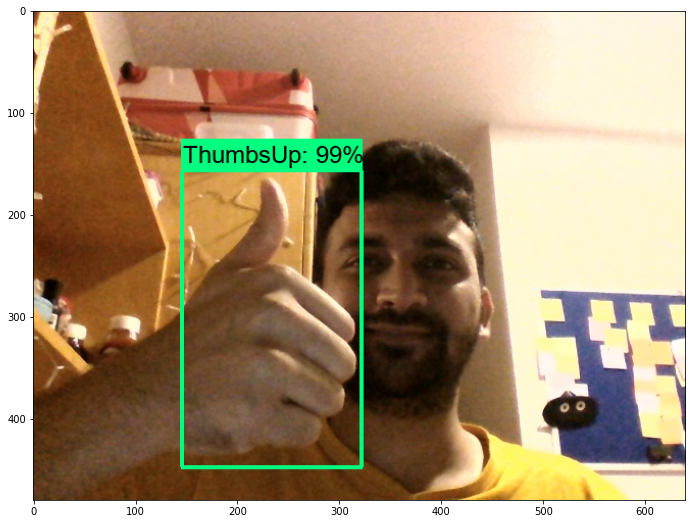

In [91]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)
plt.figure(figsize=(12,9))
plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

In [97]:
img

array([[[ 15,  52, 110],
        [ 14,  53, 108],
        [ 12,  53, 108],
        ...,
        [228, 244, 255],
        [230, 244, 255],
        [230, 244, 255]],

       [[ 17,  54, 112],
        [ 15,  53, 111],
        [ 14,  55, 110],
        ...,
        [228, 244, 255],
        [230, 244, 255],
        [230, 244, 255]],

       [[ 15,  53, 111],
        [ 15,  55, 113],
        [ 17,  60, 117],
        ...,
        [228, 244, 255],
        [228, 244, 255],
        [228, 244, 255]],

       ...,

       [[ 26,  54,  88],
        [ 22,  51,  82],
        [ 22,  51,  82],
        ...,
        [212, 248, 255],
        [212, 248, 255],
        [212, 248, 255]],

       [[ 25,  53,  88],
        [ 23,  51,  86],
        [ 24,  52,  87],
        ...,
        [211, 248, 255],
        [211, 247, 255],
        [211, 247, 255]],

       [[ 27,  54,  91],
        [ 29,  56,  93],
        [ 30,  58,  93],
        ...,
        [209, 248, 255],
        [211, 247, 255],
        [211, 247, 255]]

## Real Time Detections from the Webcam

In [ ]:
# !pip uninstall opencv-python-headless -y 
# !pip install opencv-python --upgrade

In [119]:
# !pip uninstall opencv-python 
# !pip install opencv-python

In [16]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    if frame is None:
        print("disconnected!")
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

## Freezing the Graph

In [17]:
FREEZE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'exporter_main_v2.py ')

In [18]:
command = "python {} --input_type=image_tensor --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(FREEZE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['OUTPUT_PATH'])
print(command)

python Tensorflow\models\research\object_detection\exporter_main_v2.py  --input_type=image_tensor --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --trained_checkpoint_dir=Tensorflow\workspace\models\my_ssd_mobnet --output_directory=Tensorflow\workspace\models\my_ssd_mobnet\export


In [19]:
# wait
!{command}

2022-08-05 04:12:46.896023: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-05 04:12:47.399035: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2781 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W0805 04:12:48.472626 14904 deprecation.py:623] From E:\Study Material\ASL scratch\venv\tf_asl\lib\site-packages\tensorflow\python\autograph\impl\api.py:458:

## Conversion to TFJS

In [20]:
!pip install tensorflowjs

^C


In [29]:
command = "tensorflowjs_converter --input_format=tf_saved_model --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' --output_format=tfjs_graph_model --signature_name=serving_default {} {}".format(os.path.join(paths['OUTPUT_PATH'], 'saved_model'), paths['TFJS_PATH'])
print(command)

tensorflowjs_converter --input_format=tf_saved_model --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' --output_format=tfjs_graph_model --signature_name=serving_default Tensorflow\workspace\models\my_ssd_mobnet\export\saved_model Tensorflow\workspace\models\my_ssd_mobnet\tfjsexport


In [22]:
# wait
!{command}

'tensorflowjs_converter' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
# Test Code: https://github.com/nicknochnack/RealTimeSignLanguageDetectionwithTFJS

## Conversion to TFLite

In [30]:
TFLITE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'export_tflite_graph_tf2.py ')

In [31]:
command = "python {} --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(TFLITE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['TFLITE_PATH'])
print(command)

python Tensorflow\models\research\object_detection\export_tflite_graph_tf2.py  --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --trained_checkpoint_dir=Tensorflow\workspace\models\my_ssd_mobnet --output_directory=Tensorflow\workspace\models\my_ssd_mobnet\tfliteexport


In [25]:
# wait
!{command}

     ---------------------------------------- 78.4/78.4 kB 4.3 MB/s eta 0:00:00
     -------------------------------------- 903.8/903.8 kB 2.6 MB/s eta 0:00:00
     ---------------------------------------- 40.9/40.9 kB 2.0 MB/s eta 0:00:00
     -------------------------------------- 444.1/444.1 MB 1.2 MB/s eta 0:00:00
     ---------------------------------------- 5.8/5.8 MB 3.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.0
    Uninstalling protobuf-3.19.0:
      Successfully uninstalled protobuf-3.19.0
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.1
    Uninstalling tens

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'E:\\Study Material\\ASL scratch\\venv\\tf_asl\\Lib\\site-packages\\~ensorflow\\compiler\\tf2tensorrt\\_pywrap_py_utils.pyd'
Check the permissions.

2022-08-05 04:17:55.800819: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-05 04:17:56.399230: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2781 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1
2022-08-05 04:18:01.865651: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2781 MB me

In [32]:
FROZEN_TFLITE_PATH = os.path.join(paths['TFLITE_PATH'], 'saved_model')
TFLITE_MODEL = os.path.join(paths['TFLITE_PATH'], 'saved_model', 'detect.tflite')

In [33]:
command = "tflite_convert \
--saved_model_dir={} \
--output_file={} \
--input_shapes=1,300,300,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--inference_type=FLOAT \
--allow_custom_ops".format(FROZEN_TFLITE_PATH, TFLITE_MODEL, )
print(command)

tflite_convert --saved_model_dir=Tensorflow\workspace\models\my_ssd_mobnet\tfliteexport\saved_model --output_file=Tensorflow\workspace\models\my_ssd_mobnet\tfliteexport\saved_model\detect.tflite --input_shapes=1,300,300,3 --input_arrays=normalized_input_image_tensor --output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' --inference_type=FLOAT --allow_custom_ops


In [28]:
# wait
!{command}

Estimated count of arithmetic ops: 1.710 G  ops, equivalently 0.855 G  MACs


2022-08-05 04:18:31.490370: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-05 04:18:31.968493: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2781 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1
2022-08-05 04:18:40.570165: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-08-05 04:18:40.570181: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-08-05 04:18:40.570925: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: Tensorflow\workspace\models\my_ssd_mobne

## Zip and Export Models 

In [34]:
!tar -czf models.tar.gz {paths['CHECKPOINT_PATH']}

In [35]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'